# PermRowCol experimental results

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.

First, we specify some code to read the dataset of CNOT circuits that was used in [ArXiv 1904.00633](https://arxiv.org/pdf/1904.00633.pdf). Since the original paper only used 20 circuits per test case (number of qubits, number of original CNOTs), we generated 80 more circuits that are now available on this GitHub repository in the folder circuits/steiner/

In [2]:
def read_circuit(source):
    if not os.path.exists(source):
        print("File {} does not exist".format(source))
        return
    return cnot_mapper.CNOT_tracker.from_qasm_file(source)

def read_circuits(n_qubits):
    source_folder = "../circuits/steiner/"
    circuits = []
    sources = []
    subfolder = os.path.join(source_folder, str(n_qubits)+"qubits/")

    for folder in os.listdir(subfolder):
        folder = os.path.join(subfolder, folder)
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if file.endswith(".qasm"):
                    src = os.path.join(folder, file)
                    circuit = read_circuit(src)
                    circuits.append(circuit)
                    sources.append(src)
    return circuits, sources

In [3]:
archs = [
    architecture.create_architecture(architecture.SQUARE, n_qubits=9),
    architecture.create_architecture(architecture.SQUARE, n_qubits=16),
    architecture.create_architecture(architecture.RIGETTI_16Q_ASPEN),
    architecture.create_architecture(architecture.IBM_QX5),
    architecture.create_architecture(architecture.IBM_Q20_TOKYO)
]

Then we run our experiment with the algorithms as they are.

In [4]:
def run_steiner_gauss(circuit, arch):
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.STEINER_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True)
    return c.count_cnots()

def run_rowcol(circuit, arch):
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.ROWCOL_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True)
    return c.count_cnots()

def run_perm_rowcol(circuit, arch, chooseRow=None, chooseColumn=None):
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.permrowcol(circuit.matrix.copy(), architecture=arch, y=c, chooseRow=chooseRow, chooseColumn=chooseColumn)
    return c.count_cnots()

def run_experiment(arch):
    n_qubits = arch.n_qubits
    og_circuits, srcs = read_circuits(n_qubits)
    results = pd.DataFrame()

    method = {
        "SteinerGauss": run_steiner_gauss,
        "RowCol": run_rowcol,
        "PermRowCol": run_perm_rowcol
    }

    results["Original"] = np.array([int(src.split("/")[-2]) for src in srcs])
    results["#Qubits"] = np.array([n_qubits]*len(og_circuits))
    results["Architecture"] = np.array([arch.name]*len(og_circuits))
    
    for m, func in method.items():
        results[(m, "count")] = np.array([func(c, arch) for c in og_circuits])
        results[(m, "overhead (%)")] = (results[(m, "count")]/results["Original"] - 1)*100

    results = results.groupby(["Original", "Architecture", "#Qubits"]).mean()

    results.columns = pd.MultiIndex.from_tuples(results.columns.tolist())    
    return results

In [5]:
results = pd.concat([run_experiment(arch) for arch in archs])
results.to_csv("PermRowCol results.csv")

The PermRowCol algorithm relies on heuristical functions for determining which row and column to pick. Below are some example functions to to play around with. By default, the behavior uses `ChooseRowMin` and `ChooseRowMax` (hardcoded in `permrowcol`).

In [6]:
def chooseRowMin(m, o):
    return o[np.argmin([sum(m.data[i]) for i in o])]

def chooseColumnMin(m, r, o):
    return o[np.argmin([sum(m.data[i]) if m.data[r][i] == 1 else len(m.data) for i in o])] 

def chooseRowMax(m, o):
    return o[np.argmax([sum(m.data[i]) for i in o])]

def chooseColumnMax(m, r, o):
    return o[np.argmax([sum(m.data[i]) if m.data[r][i] == 1 else 0 for i in o])] 

## Unconstrained experiments
Because there are more applications for Gaussian elimination where the number of steps are counted and the resulting matrix can also be a permutation matrix, we also compare our algorithm in case that there are no connectivity constraints. 

For example, this can be useful in ZX diagram extraction.

In [7]:
fully_connected_archs = [architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=n) for n in [5, 9, 16, 20]]

In [8]:
results = pd.concat([run_experiment(arch) for arch in fully_connected_archs])
results.to_csv("PermRowCol results UNCONSTRAINED.csv")

# Visualization


In [9]:
def plot_results(filename, architectures):
    df = pd.read_csv(filename, header=[0,1,2])
    for i, arch in enumerate(architectures):
        tmp_df = df[df[df.columns[1]] == arch.name]
        original = tmp_df[df.columns[0]]
        steinergauss = tmp_df[df.columns[3]]
        rowcol = tmp_df[df.columns[5]]
        permrowcol = tmp_df[df.columns[7]]

        plt.figure(i)
        plt.plot(original, original, label="x=y")
        plt.plot(original, steinergauss, label="Steiner-Gauss")
        plt.plot(original, rowcol, label="RowCol")
        plt.plot(original, permrowcol, label="PermRowCol")
        plt.xlabel("Original CNOT count")
        plt.ylabel("Routed CNOT count")
        plt.title(arch.name)
        plt.legend()
        plt.savefig("figs/"+arch.name, dpi=150)
        plt.show()


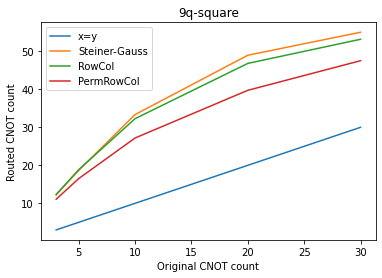

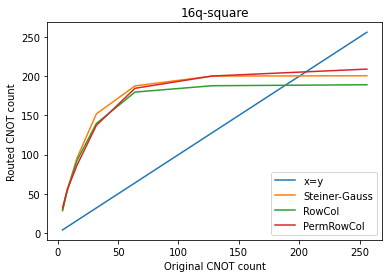

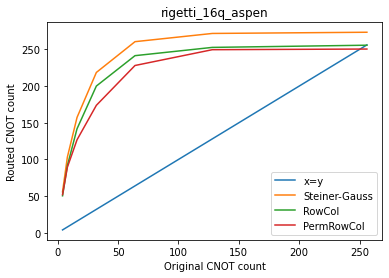

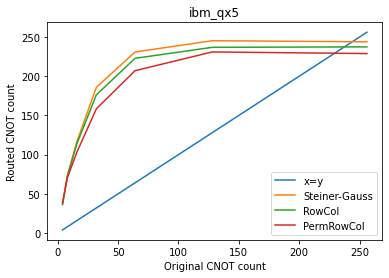

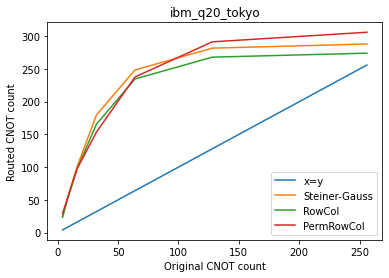

In [10]:
filename = "PermRowCol results.csv"
plot_results(filename, archs)

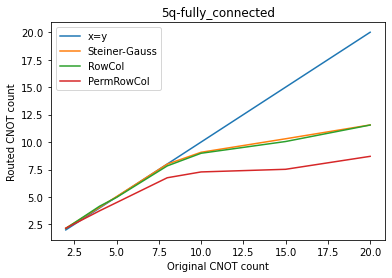

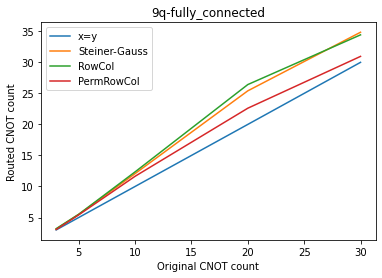

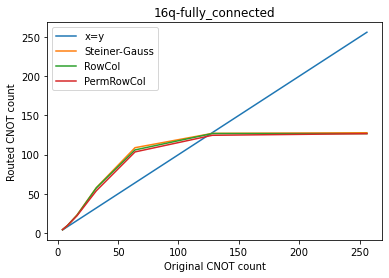

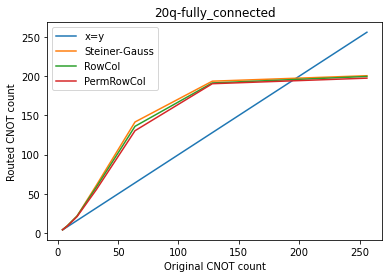

In [11]:
filename = "PermRowCol results UNCONSTRAINED.csv"
plot_results(filename, fully_connected_archs)

# Work in progress

The following code is still under development and the results are currently unreliable. 

## Genetic algorithm vs reverse traversal
Note that these numbers do not correspond with the original paper for the SteinerGauss algorithm. The reason is that in the paper, we used a genetic algorithm to improve the mapping of the circuit. 
However, we can see that for the algorithms on their own the new PermRowCol algorithm is consistently finding less CNOTs.

Next, we will compare the results with the genetic algorithm for optimizing the initial qubit mapping for the SteinerGauss and RowCol algorithms, and compare that against the PermRowCol combined with a Reverse Traversal strategy for optimizing the mapping.

In [ ]:
# Genetic algorithm parameters per #qubits
GA_parameters = {
    9: {
        "population": 30,
        "iter" : 5,
        "crossover": 0.8,
        "mutation":0.2
    },
    16: {
        "population": 50,
        "iter" : 100,
        "crossover": 0.8,
        "mutation":0.2
    },
    20: {
        "population": 100,
        "iter" : 100,
        "crossover": 0.8,
        "mutation":0.2
    },
}

# Reverse traversal parameters
RT_parameters = {
    "max_iter" : 100
}

def run_genetic_steiner_gauss(circuit, arch):
    params = GA_parameters[circuit.n_qubits]
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.GENETIC_GAUSS_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True,
                        population_size=params["population"], n_iterations=params["iter"], crossover_prob=params["crossover"], mutate_prob=params["mutation"])
    return c.count_cnots()

def run_genetic_rowcol(circuit, arch): # TODO make this functional
    params = GA_parameters[circuit.n_qubits]
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.GENETIC_ROWCOL_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True,
                        population_size=params["population"], n_iterations=params["iter"], crossover_prob=params["crossover"], mutate_prob=params["mutation"])
    return c.count_cnots()

def run_genetic_permrowcol(circuit, arch): # TODO make this functional
    params = GA_parameters[circuit.n_qubits]
    c = cnot_mapper.CNOT_tracker(circuit.n_qubits)
    cnot_mapper.gauss(cnot_mapper.GENETIC_PERMROWCOL_MODE, circuit.matrix.copy(), architecture=arch, y=c, full_reduce=True,
                        population_size=params["population"], n_iterations=params["iter"], crossover_prob=params["crossover"], mutate_prob=params["mutation"])
    return c.count_cnots()


def run_reverse_traversal(circuit, arch): # TODO test that these results are semantic preserving
    circuit, initial_mapping, output_mapping = cnot_mapper.reverse_traversal(circuit.matrix.copy(), architecture=arch)
    return circuit.count_cnots()

def run_GA_experiment(arch):
    n_qubits = arch.n_qubits
    og_circuits, srcs = read_circuits(n_qubits)
    results = pd.DataFrame()

    method = {
        "ReverseTraversal" : run_reverse_traversal,
        "PermRowCol": run_genetic_permrowcol,
        "SteinerGauss": run_genetic_steiner_gauss,
        "RowCol": run_genetic_rowcol
    }

    results["Original"] = np.array([int(src.split("/")[-2]) for src in srcs])
    results["#Qubits"] = np.array([n_qubits]*len(og_circuits))
    results["Architecture"] = np.array([arch.name]*len(og_circuits))
    
    for m, func in method.items():
        results[(m, "count")] = np.array([func(c, arch) for c in og_circuits])
        results[(m, "overhead (%)")] = (results[(m, "count")]/results["Original"] - 1)*100
        print(results.groupby(["Original", "Architecture", "#Qubits"]).mean())

    results = results.groupby(["Original", "Architecture", "#Qubits"]).mean()

    results.columns = pd.MultiIndex.from_tuples(results.columns.tolist())   
    print(results) 
    return results

In [ ]:
results = pd.concat([run_GA_experiment(arch) for arch in archs])
results.to_csv("PermRowCol results GA.csv")
results